# Appendix 15 Textual Analysis (Gender / Vote Differential)

After defining functions to carry out textual analysis, we analysis word frequencies along gender lines, and then vote-differential lines.

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plot

In [2]:
# Import the corpus
tweets = pd.read_excel("05sotu_with_tb_sentiment.xlsx")

Define three functions to produce word frequency tables and word clouds:

In [3]:
# This function takes the tweet dataframe as an argument (it uses the 'text' column which contains the tweet text)
# It returns a word frequency distribution for that dataset
def getWordFrequencies(tweets):
    # Put input in one long string
    a = tweets['text'].str.cat(sep=' ')
    
    # Tokenize words
    tweetwords = nltk.tokenize.word_tokenize(a)
    
    # Remove stopwords including AMP & ellipsis (which had ended up evading pre-processing!)
    stop_words = list(stopwords.words('english'))
    stop_words.append("AMP")
    stop_words.append("…")
    stop_words_upper = [element.upper() for element in stop_words]
    tweetwords_filtered = [w for w in tweetwords if not w in stop_words_upper]
    
    # Produce frequency table of top 50 words used in tweet corpus
    word_dist = nltk.FreqDist(tweetwords_filtered)
    return(word_dist)

In [4]:
# This function takes a word frequency distribution as an argument, and a number specifying how many words you want to view
# It returns a pd dataframe showing the [number] most common words and their frequencies
def getWordFrequencyTable(frequencydist, number):
    return pd.DataFrame(frequencydist.most_common(number))

In [5]:
# This function takes a word frequency distribution as an argument, and a string which is what you want to save your word cloud as
# It generates and saves as PNG file a wordcloud based on that frequency distribution
def saveWordCloudFromFreq(frequencydist, filename):
    # Generate wordcloud from the frequencies previously extracted
    mask = np.array(Image.open("map.jpg"))
    wc = WordCloud(background_color="black", mask = mask)
    wc.generate_from_frequencies(frequencydist)
    wc.to_file(filename + ".png")
    print("wordcloud saved as " + filename + ".png")

<h3>Word Frequencies By Gender</h3>

In [6]:
# Process female tweets - get frequency distributions for words used in female tweets, put into PD dataframe
F_words = getWordFrequencies(tweets.loc[tweets['gender'] == 'F'])
F_word_series = (F_words)
F_word_table = pd.Series(F_word_series).to_frame()
F_word_table = F_word_table.reset_index()
print(F_word_table.sort_values(by=[0], ascending=False).head)

<bound method NDFrame.head of              index     0
23918        TRUMP  6983
13363         LIKE  3805
16790       PEOPLE  3085
17702    PRESIDENT  2378
1302     AMERICANS  2236
25221     WATCHING  2169
1299      AMERICAN  2090
1298       AMERICA  1797
4431      CLAPPING  1730
9774           GET  1721
15940          ONE  1718
23372         TIME  1691
21600       SPEECH  1603
23514      TONIGHT  1531
4597          COAL  1523
21860        STAND  1475
12874         KNOW  1449
6250     DEMOCRATS  1439
19477        RIGHT  1391
4474         CLEAN  1375
9979         GOING  1366
7230      DREAMERS  1323
9950           GOD  1295
24669           US  1286
8169         EVERY  1255
10179        GREAT  1251
25144         WANT  1198
13598         LOOK  1184
8605        FAMILY  1139
6289          DEMS  1138
...            ...   ...
15205    NASTINESS     1
15204       NASHUA     1
15203      NASEOUS     1
4619           COB     1
4625         COCKS     1
15172       NANCYS     1
15173       NANCY—  

In [7]:
# Process male tweets - get frequency distributions for words used in female tweets, put into PD dataframe
M_words = getWordFrequencies(tweets.loc[tweets['gender'] == 'M'])
M_word_series = (M_words)
M_word_table = pd.Series(M_word_series).to_frame()
M_word_table = M_word_table.reset_index()
print(M_word_table.sort_values(by=[0], ascending=False).head)

<bound method NDFrame.head of                 index      0
28093           TRUMP  11122
15944            LIKE   5275
19845          PEOPLE   3881
20870       PRESIDENT   3458
1568         AMERICAN   2629
1572        AMERICANS   2609
1565          AMERICA   2582
25474          SPEECH   2579
7451        DEMOCRATS   2451
11677             GET   2348
27472            TIME   2325
18893             ONE   2301
29670        WATCHING   2217
5280         CLAPPING   2075
5487             COAL   2016
25764           STAND   1996
27635         TONIGHT   1984
23057           RIGHT   1877
11885           GOING   1873
15332            KNOW   1782
5339            CLEAN   1769
12120           GREAT   1762
9721            EVERY   1690
30341           WOULD   1583
25826           STATE   1572
11913            GOOD   1545
16210            LOOK   1538
25774        STANDING   1494
5267             CLAP   1490
28962              US   1484
...               ...    ...
9080       ELECTIONS…      1
20130        

#### Comparison of most tweeted words by gender:

In [8]:
# See how many words total (without stopwords) were used by tweeters of each gender, and assign these values to variables
print(F_words)
print(M_words)
count_Fwords = 415118
count_Mwords = 553386

<FreqDist with 26478 samples and 415118 outcomes>
<FreqDist with 31010 samples and 553386 outcomes>


Combine these two frequency distributions into one table, replace NaNs with 0:

In [9]:
# Rename columns in the male and female word frequency tables
M_word_table.columns = ['word', 'freq']
F_word_table.columns = ['word', 'freq']

# Merge those two tables on the word column
comparison = pd.merge(M_word_table, F_word_table, on='word', how='outer')
comparison.columns = ['word', 'Mfreq', 'Ffreq']

# Replace any resulting NaNs with 0
comparison = comparison.fillna(value=0)

In [10]:
# Create columns that show for each word, what percentage it is of all words tweeted by F / all words tweeted by M
comparison['F_percentage'] = (comparison['Ffreq']/count_Fwords)*100
comparison['M_percentage'] = (comparison['Mfreq']/count_Mwords)*100

# Create a column that shows for each word, the difference between the amount it was tweeted by female and male tweeters, in terms of being a percentage of the words each group used
comparison['difference'] = comparison['F_percentage']-comparison['M_percentage']

Calculate p-values for each row, using the statsmodel propotions_ztest, include this information in the dataframe

In [11]:
from statsmodels.stats.proportion import proportions_ztest

comparison['p-value'] = ""

# Calculate and record p-value for each row
for i in range(len(comparison)):
    stat, pval = proportions_ztest( [(comparison.at[i,"Mfreq"]), (comparison.at[i,"Ffreq"])], [count_Mwords,count_Fwords])
    comparison.at[i, "p-value"] = round(pval, 3)

In [12]:
# View table
print(comparison.sort_values(by=['difference'], ascending=True))
print(comparison.head)
print(comparison.shape)

                 word    Mfreq   Ffreq  F_percentage  M_percentage  \
28093           TRUMP  11122.0  6983.0      1.682172      2.009809   
7451        DEMOCRATS   2451.0  1439.0      0.346648      0.442910   
25474          SPEECH   2579.0  1603.0      0.386155      0.466040   
20870       PRESIDENT   3458.0  2378.0      0.572849      0.624880   
12376             GUY    740.0   362.0      0.087204      0.133722   
25826           STATE   1572.0  1007.0      0.242582      0.284069   
8412           DONALD    892.0   506.0      0.121893      0.161189   
26909             TAX   1277.0   801.0      0.192957      0.230761   
15944            LIKE   5275.0  3805.0      0.916607      0.953223   
1565          AMERICA   2582.0  1797.0      0.432889      0.466582   
14135  INFRASTRUCTURE    903.0   539.0      0.129843      0.163177   
1911          APPLAUD    563.0   287.0      0.069137      0.101737   
30341           WOULD   1583.0  1057.0      0.254626      0.286057   
9718             EVE

In [13]:
# Filter out all rows with p value greater than 0.05
comparison_significant = comparison[comparison["p-value"]<=0.05]
print(comparison_significant.shape)

(1592, 7)


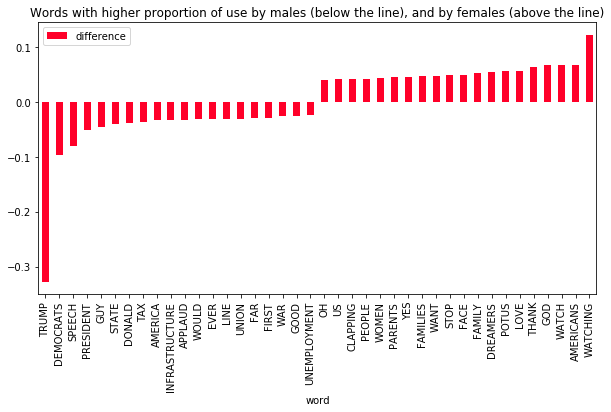

In [14]:
# Create ew table consisting of top 20 and bottom 20 rows (the rows with the biggest pro F difference and the biggest pro M difference)
comparison_reduced = comparison_significant.sort_values(by=['difference'], ascending=True).head(20)
comparison_reduced = comparison_reduced.append(comparison_significant.sort_values(by=['difference'], ascending=False).head(20))
# View this on a bar graph
comparison_reduced.sort_values(by=['difference'], ascending=True).plot(x='word', y='difference', kind='bar', title = "Words with higher proportion of use by males (below the line), and by females (above the line)", colormap = "gist_rainbow", legend=True, figsize=(10,5), sort_columns=False)

### Analysis of most tweeted words by extreme blue vs extreme red states:


In [15]:
# Import information about each state's Clinton vote share vs Trump vote share

import pandas as pd
vote_share = pd.read_excel("vote_share.xlsx")
vote_share["T_C_differential"] = vote_share["T_vote_share"] - vote_share["C_vote_share"]

# Add this information into our dataset of tweets (for each tweet, cross reference location and add the data)
tweets["T_C_differential"]=""
for i in range(len(tweets)):
    for j in range (len(vote_share)):
        if (tweets.at[i, "state"])== (vote_share.at[j, "STATE"]):
            tweets.at[i, "T_C_differential"] = vote_share.at[j, "T_C_differential"]
            
# Change the datatype to be a float rather than a string
print(tweets["T_C_differential"].dtype)
tweets["T_C_differential"] = pd.to_numeric(tweets["T_C_differential"])
print(tweets["T_C_differential"].dtype)

object
float64


In [16]:
# Process Trump voting states with differential 0.19835 or higher
red_words = getWordFrequencies(tweets.loc[tweets['T_C_differential']>=0.19835])
red_word_series = (red_words)
red_word_table = pd.Series(red_word_series).to_frame()
red_word_table = red_word_table.reset_index()
print(red_word_table.sort_values(by=[0], ascending=False).head)

<bound method NDFrame.head of            index     0
9650       TRUMP  1355
5399        LIKE   738
6762      PEOPLE   575
7114   PRESIDENT   476
527    AMERICANS   398
526     AMERICAN   398
525      AMERICA   374
10189   WATCHING   338
9490     TONIGHT   332
2546   DEMOCRATS   331
9433        TIME   327
3979         GET   308
8715      SPEECH   308
6406         ONE   308
8813       STAND   290
1779    CLAPPING   287
4131       GREAT   273
3295       EVERY   258
4052       GOING   253
1850        COAL   251
5188        KNOW   249
7869       RIGHT   245
10151       WANT   245
5498        LOOK   242
4065        GOOD   234
8816    STANDING   232
4043         GOD   227
8840       STATE   226
1799       CLEAN   223
1775        CLAP   212
...          ...   ...
5219      LABORS     1
5218    LABORING     1
5254      LATELY     1
846     BABYFACE     1
5301        LEAP     1
5257      LATER…     1
5300       LEANS     1
5299        LEAN     1
5297      LEAGUE     1
5296       LEADS     1
5290

In [17]:
# Process Clinton voting states with differential -0.110775 or lower
blue_words = getWordFrequencies(tweets.loc[tweets['T_C_differential']<=-0.110775])
blue_word_series = (blue_words)
blue_word_table = pd.Series(blue_word_series).to_frame()
blue_word_table = blue_word_table.reset_index()
print(blue_word_table.sort_values(by=[0], ascending=False).head)

<bound method NDFrame.head of                 index      0
28020           TRUMP  11582
15880            LIKE   4687
19760          PEOPLE   3862
20785       PRESIDENT   3272
1623         AMERICAN   2786
1626        AMERICANS   2645
18836             ONE   2320
29581        WATCHING   2261
1620          AMERICA   2210
27414            TIME   2204
25428          SPEECH   2203
5499             COAL   2106
11628             GET   2065
27561         TONIGHT   1926
5340            CLEAN   1871
5286         CLAPPING   1868
23032           RIGHT   1809
28892              US   1780
15257            KNOW   1720
11852           GOING   1669
25770           STATE   1579
9697            EVERY   1574
29857           WHITE   1530
12085           GREAT   1508
30246           WOULD   1486
25711           STAND   1477
7429        DEMOCRATS   1459
10188          FAMILY   1447
8594         DREAMERS   1444
21910          REALLY   1381
...               ...    ...
18719   OFFFFFFFFFFFF      1
18702        

In [18]:
# See how many words total (without stopwords) were used by tweeters of each category, and assign these values to variables
print(blue_words)
print(red_words)
count_bluewords = 550374
count_redwords = 75573

<FreqDist with 30958 samples and 550374 outcomes>
<FreqDist with 10606 samples and 75573 outcomes>


In [19]:
# Rename columns in the Trump voting and Clinton voting word frequency tables
red_word_table.columns = ['word', 'freq']
blue_word_table.columns = ['word', 'freq']

# Merge those two tables on the word column
comparison2 = pd.merge(red_word_table, blue_word_table, on='word', how='outer')
comparison2.columns = ['word', 'Redfreq', 'Bluefreq']

# Replace any resulting NaNs with 0
comparison2 = comparison2.fillna(value=0)

In [20]:
# Create columns that show for each word, what percentage it is of all words tweeted by Red states/ all words tweeted by Blue states
comparison2['Red_percentage'] = (comparison2['Redfreq']/count_redwords)*100
comparison2['Blue_percentage'] = (comparison2['Bluefreq']/count_bluewords)*100

# Create a column that shows for each word, the difference between the amount it was tweeted by Red states / Blue states, in terms of being a percentage of the words each group used
comparison2['difference'] = comparison2['Red_percentage']-comparison2['Blue_percentage']

In [21]:
# Calculate p values

from statsmodels.stats.proportion import proportions_ztest

comparison2['p-value'] = ""

# Calculate and record p-value for each row
for i in range(len(comparison2)):
    stat, pval = proportions_ztest( [(comparison2.at[i,"Redfreq"]), (comparison2.at[i,"Bluefreq"])], [count_redwords,count_bluewords])
    comparison2.at[i, "p-value"] = round(pval, 3)

In [22]:
print(comparison2.sort_values(by=['difference'], ascending=True))
print(comparison2.head)
print(comparison2.shape)
# Filter out all rows with a p value  greater than 0.05
comparison2_significant = comparison2[comparison2["p-value"]<=0.05]
print(comparison2_significant.shape)

              word  Redfreq  Bluefreq  Red_percentage  Blue_percentage  \
9650         TRUMP   1355.0   11582.0        1.792968         2.104387   
10287        WHITE    141.0    1530.0        0.186575         0.277993   
4694    IMMIGRANTS     88.0    1106.0        0.116444         0.200954   
8060          SAYS    130.0    1306.0        0.172019         0.237293   
1099         BLACK    139.0    1347.0        0.183928         0.244743   
2853        DONALD     71.0     830.0        0.093949         0.150807   
1850          COAL    251.0    2106.0        0.332129         0.382649   
5787       MENTION     34.0     499.0        0.044990         0.090666   
1799         CLEAN    223.0    1871.0        0.295079         0.339951   
9933            US    212.0    1780.0        0.280523         0.323416   
9741             U     42.0     532.0        0.055575         0.096662   
6879          PLAN     59.0     643.0        0.078070         0.116830   
5768       MELANIA     59.0     643.0 

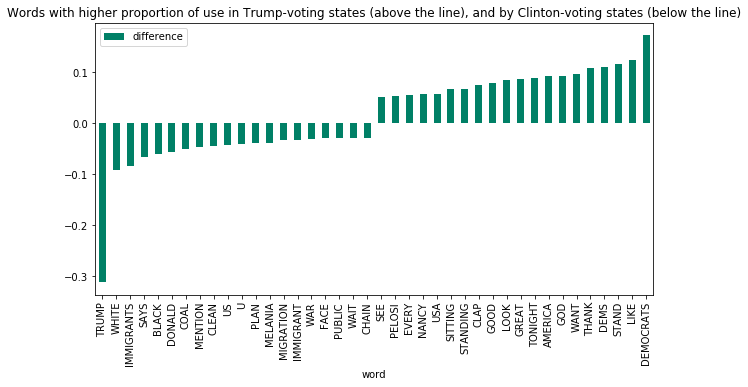

In [23]:
# New table consisting of top 20 and bottom 20 rows (the rows with the biggest pro F difference and the biggest pro M difference)
comparison2_reduced = comparison2_significant.sort_values(by=['difference'], ascending=True).head(20)
comparison2_reduced = comparison2_reduced.append(comparison2_significant.sort_values(by=['difference'], ascending=False).head(20))
# View on bar graph
comparison2_reduced.sort_values(by=['difference'], ascending=True).plot(x='word', y='difference', kind='bar', title = "Words with higher proportion of use in Trump-voting states (above the line), and by Clinton-voting states (below the line)", colormap = "summer", legend=True, figsize=(10,5), sort_columns=False)